In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [8]:
loaders = {
    "train": DataLoader(train_data, batch_size=10, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=10, shuffle=False, num_workers=1),
}

In [9]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [11]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders["train"].dataset),
                100. * batch_idx / len(loaders["train"]), loss.item()))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders["test"].dataset),
        100. * correct / len(loaders["test"].dataset)))

In [12]:
for epoch in range(1, 51):
    train(epoch)
    test()

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292042
Train Epoch: 1 [200/60000 (0%)]	Loss: 2.332169
Train Epoch: 1 [400/60000 (1%)]	Loss: 2.316312
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.172443
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.055781
Train Epoch: 1 [1000/60000 (2%)]	Loss: 1.722071
Train Epoch: 1 [1200/60000 (2%)]	Loss: 1.342091
Train Epoch: 1 [1400/60000 (2%)]	Loss: 1.130459
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.255167
Train Epoch: 1 [1800/60000 (3%)]	Loss: 1.252561
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.123911
Train Epoch: 1 [2200/60000 (4%)]	Loss: 1.216627
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.872781
Train Epoch: 1 [2600/60000 (4%)]	Loss: 1.162778
Train Epoch: 1 [2800/60000 (5%)]	Loss: 1.067383
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.879338
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.643917
Train Epoch: 1 [3400/60000 (6%)]	Loss: 0.501423
Train Epoch: 1 [3600/60000 (6%)]	Loss: 0.541407
Train Epoch: 1 [3800/60000 (6%)]	Loss: 0.620595
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.306360

Prediction:  1


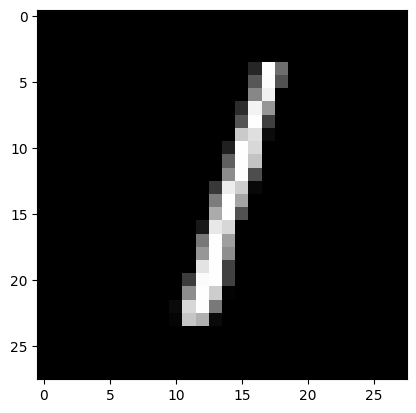

In [13]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[2]
data = data.unsqueeze(0).to(device)
output = model(data)

print("Prediction: ", output.argmax(dim = 1, keepdim = True).item())

plt.imshow(data.squeeze(0).squeeze(0).cpu().numpy(), cmap="gray")
plt.show()